<div align="center">
  
# ***The Single-Item Uncapacitated Lot-Sizing Problem (SI-ULSP)***
### *Group7*

</div>


---

This notebook presents the implementation of programmed models to solve the **Single-Item Uncapacitated Lot-Sizing Problem (SI-ULSP)** under two different settings. The first part addresses the problem **without backlogging**, ensuring that all demand is met in the period it occurs. The second part extends the model to allow **backlogging**, meaning demand can be fulfilled in later periods at an associated cost. Different models are tested on various instances provided for the project.

---

# *Part I*: Uncapacitated Lot-Sizing Problem without Backlogging

### ***Read file:***

In [14]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import pandas as pd
import numpy as np

class ProductionData:
    def __init__(self, demand_forecast, setup_cost, production_cost, holding_cost, num_periods):
        self.demand_forecast = np.array(demand_forecast)
        self.setup_cost = np.array(setup_cost)
        self.production_cost = np.array(production_cost)
        self.holding_cost = np.array(holding_cost)
        self.num_periods = num_periods
    
    def __repr__(self):
        return (f"ProductionData(\n"
                f"  Demand Forecast: {self.demand_forecast}\n"
                f"  Setup Cost: {self.setup_cost}\n"
                f"  Production Cost: {self.production_cost}\n"
                f"  Holding Cost: {self.holding_cost}\n"
                f"  Number of Periods: {self.num_periods}\n")

def read_production_data(file_path, sheet_name):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    # Insert dummy period 0
    demand_forecast = np.insert(df["Demand Forecast"].to_numpy(), 0, 0)
    setup_cost = np.insert(df["Setup Cost"].to_numpy(), 0, 0)
    production_cost = np.insert(df["Production cost"].to_numpy(), 0, 0)
    holding_cost = np.insert(df["Holding cost"].to_numpy(), 0, 0)
    
    num_periods = df.shape[0]
    
    return ProductionData(demand_forecast, setup_cost, production_cost, holding_cost, num_periods)

# Define file path and sheet names
file_path = "ULSP-instancesR.xlsx"
sheet_list = ["6-periods (1)", "6-periods (2)", "12-periods (1)", "12-periods (2)", 
              "24-periods (1)", "24-periods (2)", "52-periods (1)", "52-periods (2)", 
              "104-periods (1)", "104-periods (2)"]



## 1 & 2 MILP vs LP Solutions (Gurobi)

### ***MILP***

In [20]:
# DataFrame to store all results
results_df = pd.DataFrame(columns=["Sheet", "Period", "y", "x", "S"])

# Process each sheet
for sheet_name in sheet_list:
    print(f"\nProcessing sheet: {sheet_name}")

    # Read the Excel file from the specific sheet
    data=read_production_data(file_path, sheet_name)
    T=data.num_periods
    
    # Create Gurobi model
    model = gp.Model("Uncapacitated Lot-Sizing Problem")

    # Decision variables
    y = model.addVars(T+1, vtype=GRB.BINARY, name="y")  
    x = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="x")  
    S = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="S")  

    # Objective function
    model.setObjective(
        quicksum(data.setup_cost[t] * y[t] for t in range(1, T+1)) +
        quicksum(data.production_cost[t] * x[t] for t in range(1, T+1)) +
        quicksum(data.holding_cost[t] * S[t] for t in range(1, T+1)),
        GRB.MINIMIZE
    )

    # Constraints
    model.addConstr(S[0] == 0, name="no_inventory0")
    model.addConstr(S[T] == 0, name="no_inventoryT")

    for t in range(1, T+1):
        model.addConstr(x[t] + S[t-1] == data.demand_forecast[t] + S[t], name=f"demand_satisfied_{t}")
        model.addConstr(x[t] <= quicksum(data.demand_forecast[m] for m in range(t, T+1)) * y[t], name=f"setup_constraint_{t}")

    # Solve model
    model.optimize()

    if model.status == GRB.OPTIMAL:

        print(f"{'Period':<10}{'y':<10}{'x':<10}{'S':<15}")
        for t in range(1, T+1):
            y_val = y[t].X
            x_val = x[t].X
            S_val = S[t].X

            # Print results for the current period
            print(f"{t:<10}{y_val:<10}{x_val:<15}{S_val:<15}")

            # Append to DataFrame
            results_df = pd.concat([results_df, pd.DataFrame({
                "Sheet": [sheet_name],
                "Period": [t],
                "y": [y_val],
                "x": [x_val],
                "S": [S_val]
            })], ignore_index=True)
        
        
# Print all results at the end
print("\nAll results:")
print(results_df)

# Optionally save to a CSV file
results_df.to_csv("non_optimized_results.csv", index=False)
print("\nResults saved to 'non_optimized_results.csv'.")



Processing sheet: 6-periods (1)
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 14 rows, 21 columns and 32 nonzeros
Model fingerprint: 0x0695a2d9
Variable types: 14 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [3e+00, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 6e+02]
Presolve removed 7 rows and 10 columns
Presolve time: 0.01s
Presolved: 7 rows, 11 columns, 17 nonzeros
Variable types: 7 continuous, 4 integer (4 binary)
Found heuristic solution: objective 58264.000000

Root relaxation: objective 5.487500e+04, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Ga

C:\Users\Senne\AppData\Local\Temp\ipykernel_30288\3517685777.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({



CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 26 rows, 39 columns and 62 nonzeros
Model fingerprint: 0x9a0ebf4f
Variable types: 26 continuous, 13 integer (13 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+00, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 9e+02]
Found heuristic solution: objective 60593.000000
Presolve removed 7 rows and 9 columns
Presolve time: 0.00s
Presolved: 19 rows, 30 columns, 48 nonzeros
Variable types: 19 continuous, 11 integer (11 binary)

Root relaxation: objective 4.210245e+04, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 42102.4492    0    8 60593.0000 42102.4492  30.5%     -    0s
H    0     0    

### ***LP-Relaxation vs MILP solutions***

In [23]:
import time

# Function to solve ULSP for LP relaxation and MILP
def solve_ulsp(data, relax_y=False):
    T = data.num_periods
    model = gp.Model("ULSP")
    
    # Decision variables
    y = model.addVars(T+1, vtype=GRB.CONTINUOUS if relax_y else GRB.BINARY, lb=0, ub=1, name="y")
    x = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="x")  
    S = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="S")  
    
    # Objective function
    model.setObjective(
        quicksum(data.setup_cost[t] * y[t] for t in range(1, T+1)) +
        quicksum(data.production_cost[t] * x[t] for t in range(1, T+1)) +
        quicksum(data.holding_cost[t] * S[t] for t in range(1, T+1)),
        GRB.MINIMIZE
    )
    
    # Constraints
    model.addConstr(S[0] == 0, name="no_inventory0")
    model.addConstr(S[T] == 0, name="no_inventoryT")
    
    for t in range(1, T+1):
        model.addConstr(x[t] + S[t-1] == data.demand_forecast[t] + S[t], name=f"demand_satisfied_{t}")
        model.addConstr(x[t] <= quicksum(data.demand_forecast[m] for m in range(t, T+1)) * y[t], name=f"setup_constraint_{t}")
    
    # Solve model
    start_time = time.time()
    model.optimize()
    solve_time = time.time() - start_time
    
    # Store results
    obj_value = model.objVal if model.status == GRB.OPTIMAL else None
    return obj_value, solve_time, model

# Data storage
results = []

# Process each sheet
for sheet_name in sheet_list:
    print(f"\nProcessing sheet: {sheet_name}")
    
    # Read data
    data = read_production_data(file_path, sheet_name)
    
    # Solve LP relaxation
    lp_obj, lp_time, lp_model = solve_ulsp(data, relax_y=True)
    
    # Solve MILP
    milp_obj, milp_time, milp_model = solve_ulsp(data, relax_y=False)
    
    # Store results
    results.append([sheet_name, lp_obj, lp_time, milp_obj, milp_time])
    
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Sheet", "LP Objective", "LP Time", "MILP Objective", "MILP Time"])

# Print and save results
print("\nFinal Results:")
print(results_df)
results_df.to_csv("lp_vs_milp_nobacklog_results.csv", index=False)
print("Results saved to 'lp_vs_milp_results.csv'.")



Processing sheet: 6-periods (1)
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 14 rows, 21 columns and 32 nonzeros
Model fingerprint: 0xdf62efda
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [3e+00, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 6e+02]
Presolve removed 11 rows and 14 columns
Presolve time: 0.02s
Presolved: 3 rows, 7 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9136788e+04   5.367251e+01   0.000000e+00      0s
Extra simplex iterations after uncrush: 3
       6    5.1762337e+04   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.03 seconds (0.00 work units)
Optimal objective  5.176233714e+04
Gurobi Optimizer version 12.0.1 build v12.0.1

## 3. Polynomial Dynamic Programming - Wagner-Whitin

### ***Pattern Observation in MILP***

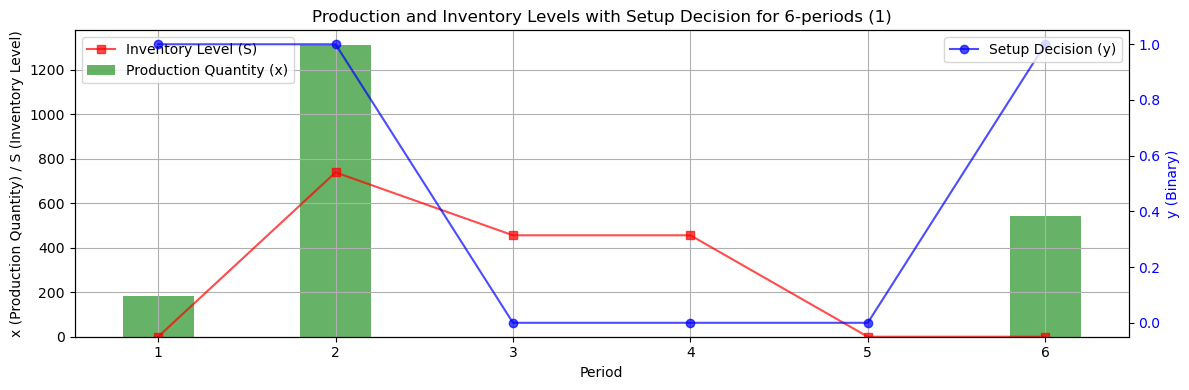

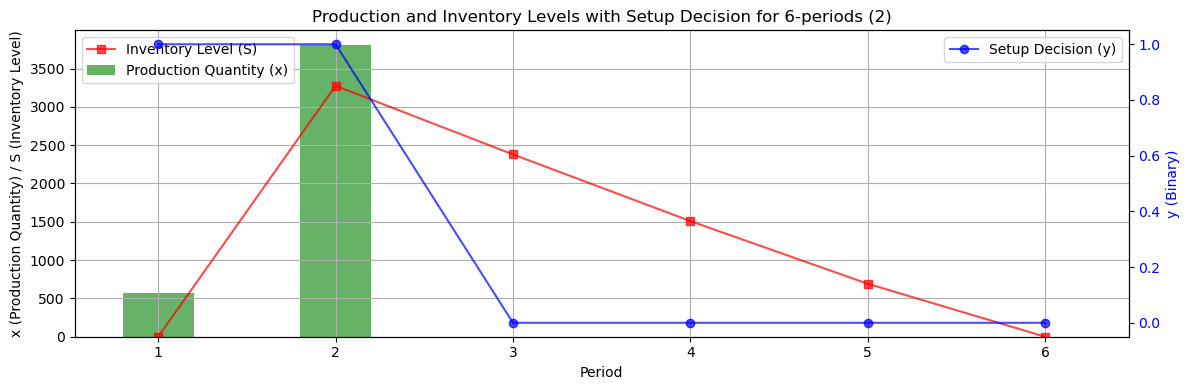

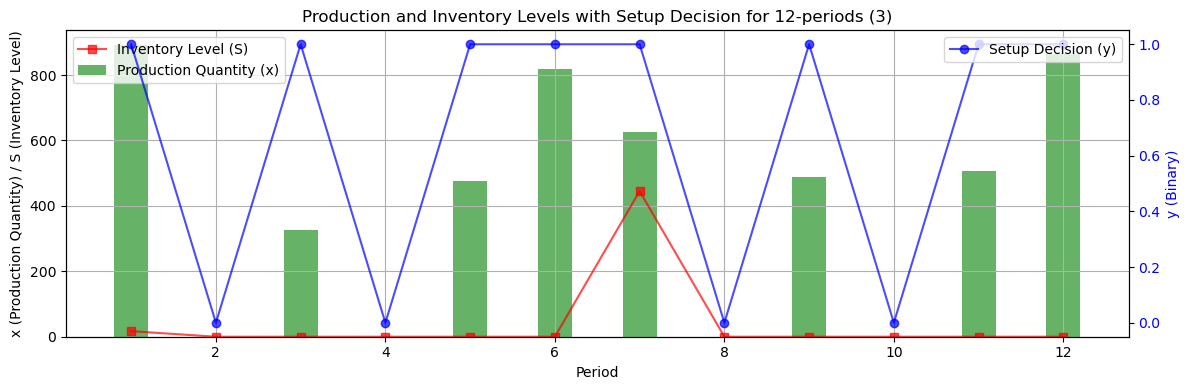

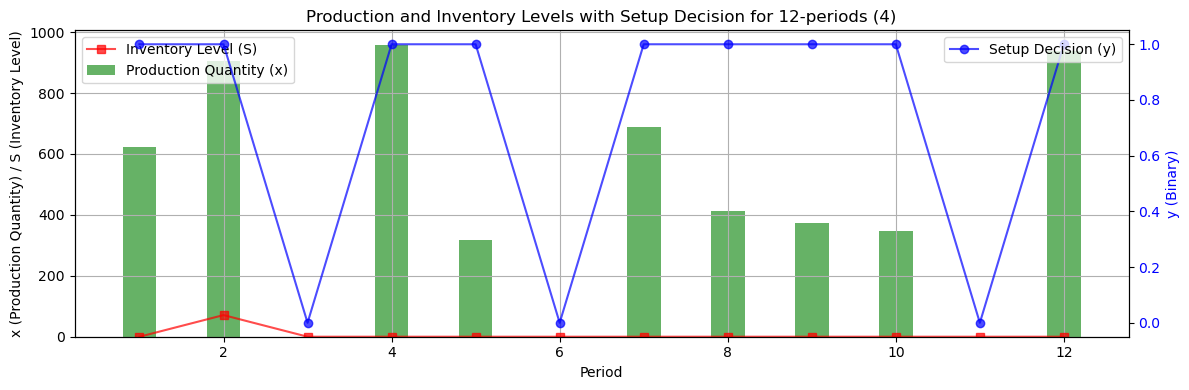

In [27]:

import matplotlib.pyplot as plt

# Load the all_results CSV file into a DataFrame
results_df = pd.read_csv("non_optimized_results.csv")

# Define function to plot data
def plot_data(data, sheet_name):
    fig, ax1 = plt.subplots(figsize=(12, 4))
    
    ax1.bar(data['Period'], data['x'], color='g', width=0.4, label='Production Quantity (x)', alpha=0.6)
    ax1.plot(data['Period'], data['S'], marker='s', linestyle='-', color='r', label='Inventory Level (S)', alpha=0.7)
    ax1.set_xlabel('Period')
    ax1.set_ylabel('x (Production Quantity) / S (Inventory Level)')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ax2.plot(data['Period'], data['y'], marker='o', linestyle='-', color='b', label='Setup Decision (y)', alpha=0.7)
    ax2.set_ylabel('y (Binary)', color='b')
    ax2.tick_params(axis='y', labelcolor='b')

    plt.title(f'Production and Inventory Levels with Setup Decision for {sheet_name}')
    ax1.grid(True)
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# spliting the CSV into instances
sheet_ranges = [
    ("6-periods (1)", 0, 6),
    ("6-periods (2)", 6, 12),
    ("12-periods (3)", 12, 24),
    ("12-periods (4)", 24, 36)
]

for sheet_name, start_row, end_row in sheet_ranges:
    sheet_data = results_df.iloc[start_row:end_row] 
    plot_data(sheet_data, sheet_name)

### ***Wagner within***

In [30]:
import numpy as np

def wagner_whitin_nobacklog(demand, setup_costs, holding_costs, unit_costs, num_periods):
    T = num_periods  # Number of periods
    C = np.full(T+1, float('inf'))  # Cost array, initialized to infinity
    C[0] = 0  # Base case: No cost at period 0
    order_periods = [-1] * (T+1)  # To track order placements
    
    # For each period t
    for t in range(1, T+1):
        # Try all possible last order periods j to find which j to produce to meet the demand
        for j in range(1, t+1): 
            # Calculate costs when producing in period j for periods j through t
            
            # Setup cost for production in period j
            cost = setup_costs[j]
            
            # Production cost for all demand from j to t
            production_cost = unit_costs[j] * sum(demand[k] for k in range(j, t+1)) #produce whatever required till t
            cost += production_cost
            
            # Holding costs for demands of periods k (j < k ≤ t)
            holding_cost = sum(
                holding_costs[k] * sum(demand[m] for m in range(k+1, t+1))
                for k in range(j, t)
            )
            cost += holding_cost
            
            # Add cost of optimal solution up to j-1
            total_cost = C[j-1] + cost #sum it to the cost of previous period
            
            # Update if this solution is better (minimum cost for j period)
            if total_cost < C[t]:
                C[t] = total_cost
                order_periods[t] = j
    
    # Backtrack to find optimal order schedule
    t = T
    orders = []
    while t > 0:
        j = order_periods[t]
        order_quantity = sum(demand[k] for k in range(j, t+1))
        orders.append((j, order_quantity))
        t = j-1
    
    return list(reversed(orders)), C[T]

results1=[]
    
for sheet_name in sheet_list:
    print(f"\nProcessing sheet: {sheet_name}")

    # Read the Excel file from the specific sheet
    data=read_production_data(file_path, sheet_name)
    #print(data.demand_forecast[0])
    #print(data.holding_cost[0])
    start_time=time.time()
    optimal_orders, min_cost = wagner_whitin_nobacklog(data.demand_forecast, data.setup_cost, data.holding_cost, data.production_cost, data.num_periods)
    total_time=time.time()-start_time

    results1.append([sheet_name, min_cost, total_time])
    
    print("Optimal order schedule:", optimal_orders)
    print("Minimum total cost:", min_cost)

# Convert results to DataFrame
results_df = pd.DataFrame(results1, columns=["Sheet", "Minimun cost", "Processing time"])

results_df.to_csv("Wagner_within_formulation.csv", index=False)


Processing sheet: 6-periods (1)
Optimal order schedule: [(1, 185), (2, 1312), (6, 542)]
Minimum total cost: 54875.0

Processing sheet: 6-periods (2)
Optimal order schedule: [(1, 573), (2, 3808)]
Minimum total cost: 105079.0

Processing sheet: 12-periods (1)
Optimal order schedule: [(1, 892), (3, 325), (5, 477), (6, 817), (7, 627), (9, 487), (11, 506), (12, 863)]
Minimum total cost: 54291.0

Processing sheet: 12-periods (2)
Optimal order schedule: [(1, 623), (2, 906), (4, 958), (5, 319), (7, 689), (8, 414), (9, 372), (10, 346), (12, 938)]
Minimum total cost: 44793.0

Processing sheet: 24-periods (1)
Optimal order schedule: [(1, 660), (2, 837), (3, 164), (5, 857), (6, 190), (9, 100), (10, 454), (11, 924), (12, 496), (13, 703), (14, 469), (15, 706), (16, 907), (17, 321), (19, 192), (22, 883), (23, 783), (24, 727)]
Minimum total cost: 78316.0

Processing sheet: 24-periods (2)
Optimal order schedule: [(1, 1067), (3, 1366), (5, 853), (7, 695), (11, 842), (13, 1245), (16, 958), (18, 585), (1

## 4. Inequalities Verification

In [33]:

# Read the Excel file from the specific sheet
data=read_production_data(file_path,"6-periods (1)" )
T=data.num_periods
    
# Create Gurobi model
model = gp.Model("Uncapacitated Lot-Sizing Problem")

# Decision variables as before ofc 
y = model.addVars(T+1, vtype=GRB.BINARY, name="y")  
x = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="x")  
S = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="S")  

# Objective function
model.setObjective(
    quicksum(data.setup_cost[t] * y[t] for t in range(1, T+1)) +
    quicksum(data.production_cost[t] * x[t] for t in range(1, T+1)) +
    quicksum(data.holding_cost[t] * S[t] for t in range(1, T+1)),
    GRB.MINIMIZE
)

# Constraints
model.addConstr(S[0] == 0, name="no_inventory0")
model.addConstr(S[T] == 0, name="no_inventoryT")

for t in range(1, T+1):
    model.addConstr(x[t] + S[t-1] == data.demand_forecast[t] + S[t])
    model.addConstr(x[t] <= quicksum(data.demand_forecast[m] for m in range(t, T+1)) * y[t])

#in this case we don't care about previous objective function, we care about checking validity of new ineq for all the variables in the polyhedron
# Define l and S for the inequality check
l = T  # Last period (you can change this dynamically)
S_subset = list(range(1, l+1))  # Example subset

# Compute D_tl values, l is fixed, tehre is a D_tl for each t, looks like it's a matrix
D = [[0] * (T+1) for x in range(T+1)] 
for l_val in range(1, T+1):  # Loop over l
    for t in range(1, l_val+1):  # Loop over t from 1 to l
        D[t][l_val] = sum(data.demand_forecast[i] for i in range(t, l_val+1))

#all constrints set

model.setParam(GRB.Param.PoolSearchMode, 2)  # Explore entire feasible region
model.setParam(GRB.Param.PoolSolutions, 10000000)  # Allow up to 1M solutions (adjust if needed)

model.optimize()

num_solutions = model.SolCount  # Get the number of feasible solutions found
print(f"Total feasible integer solutions found: {num_solutions}")


model.optimize()

print(model.solcount)


integer_solutions = []
for i in range(model.SolCount):
    model.setParam(GRB.Param.SolutionNumber, i)
    y_values = model.getAttr("Xn", y)

    # Check if all y-values are integer
    if all(abs(y_values[t] - round(y_values[t])) < 1e-6 for t in range(1, T+1)):
        integer_solutions.append(y_values)
# Iterate through the feasible solutions Gurobi found

N=len(integer_solutions)


# Verify the inequality for all integer solutions
for i in range(N):  
    y_values = integer_solutions[i]  # Directly use stored values

    # Extract x and S values
    x_values = model.getAttr("X", x)  
    S_values = model.getAttr("X", S)  

    # Compute left-hand and right-hand side for the inequality
    for l_val in range(1, T+1):
        lhs = sum(x_values[t] for t in range(1, l_val+1))
        rhs = sum(D[t][l_val] * y_values[t] for t in range(1, l_val+1)) + S_values[l_val]
        
        if lhs > rhs:
            print(f" Inequality violated at solution {i}: {lhs} > {rhs}")
            break  # Stop checking if one violation is found          
            
print("valid inequalities")
    
    

Set parameter PoolSearchMode to value 2
Set parameter PoolSolutions to value 10000000
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
PoolSolutions  10000000
PoolSearchMode  2

Optimize a model with 14 rows, 21 columns and 32 nonzeros
Model fingerprint: 0x0695a2d9
Variable types: 14 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [3e+00, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 6e+02]
Presolve removed 6 rows and 6 columns
Presolve time: 0.00s
Presolved: 8 rows, 15 columns, 20 nonzeros
Variable types: 9 continuous, 6 integer (6 binary)
Found heuristic solution: objective 60397.000000

Root relaxation: objective 5.359542e+04, 5 iterations, 0.00 seconds (0.00 work units)

    Nodes    |

## 5. & 6. Separation technique

In [37]:
# DataFrame to store all results
results_df = pd.DataFrame(columns=["Sheet", "Period", "y", "x", "S"])


sheet_list = ["24-periods (1)"]
              
#, "6-periods (2)", "12-periods (1)", "12-periods (2)", 
 #             "24-periods (1)", "24-periods (2)", "52-periods (1)", "52-periods (2)", 
  #            "104-periods (1)", "104-periods (2)"]


# Process each sheet
for sheet_name in sheet_list:
    print(f"\nProcessing sheet: {sheet_name}")
    
    # Read the Excel file from the specific sheet
    data = read_production_data(file_path, sheet_name)
    T = data.num_periods
    
    # Create Gurobi model
    model = gp.Model("Uncapacitated Lot-Sizing Problem")
    
    # Decision variables
    y = model.addVars(T+1, vtype=GRB.BINARY, name="y")  
    x = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="x")  
    S = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="S")  
    
    # Objective function
    model.setObjective(
        quicksum(data.setup_cost[t] * y[t] for t in range(1, T+1)) +
        quicksum(data.production_cost[t] * x[t] for t in range(1, T+1)) +
        quicksum(data.holding_cost[t] * S[t] for t in range(1, T+1)),
        GRB.MINIMIZE
    )

    # Constraints
    model.addConstr(S[0] == 0, name="no_inventory0")
    model.addConstr(S[T] == 0, name="no_inventoryT")

    # Relax binary constraints on y to be continuous in [0,1]
    for t in range(1, T+1):
        y[t].vtype = GRB.CONTINUOUS  # Convert binary to continuous
        y[t].lb = 0  # Lower bound
        y[t].ub = 1  # Upper bound


    for t in range(1, T+1):
        model.addConstr(x[t] + S[t-1] == data.demand_forecast[t] + S[t], name=f"demand_satisfied_{t}")
        model.addConstr(x[t] <= quicksum(data.demand_forecast[m] for m in range(t, T+1)) * y[t], name=f"setup_constraint_{t}")

    # Solve initial LP relaxation
    model.Params.InfUnbdInfo = 1  # Ensure feasibility insights
    model.optimize()
    # Retrieve LP-relaxed solution
    x_vals = {t: x[t].X for t in range(1, T+1)}
    y_vals = {t: y[t].X for t in range(1, T+1)}
    S_vals = {t: S[t].X for t in range(1, T+1)}
    
    # Print LP relaxation results
    print("\nLP Relaxation Solution:")
    for t in range(1, T+1):
        print(f"Period {t}: y={y_vals[t]:.4f}, x={x_vals[t]:.4f}, S={S_vals[t]:.4f}")

    while True:
        # Get LP relaxation solution, yeah
        x_vals = {t: x[t].X for t in range(1, T+1)}
        y_vals = {t: y[t].X for t in range(1, T+1)}
        S_vals = {t: S[t].X for t in range(1, T+1)}

        # Separation procedure: Find the most violated (l, S) inequality
        most_violated = None
        max_violation = 0
        
        for l in range(1, T+1): #for each subset, we are finding the most violated
            
            S_l = [j for j in range(1, l+1) if x_vals[j] - sum(data.demand_forecast[j:l+1]) * y_vals[j] > 0]
            
            if not S_l:
                continue
            
            v_l = sum(x_vals[t] - sum(data.demand_forecast[t:l+1]) * y_vals[t] for t in S_l) - S_vals[l]
            
            if v_l > max_violation:
                max_violation = v_l
                most_violated = (l, S_l)

        # If no violated inequalities, stop
        if max_violation <= 0:
            break
        
        # Add the most violated (l, S) inequality
        l_star, S_star = most_violated
        model.addConstr(quicksum(x[t] for t in S_star) <= quicksum(sum(data.demand_forecast[t:l_star+1]) * y[t] for t in S_star) + S[l_star], name=f"(l,S)_ineq_{l_star}")
        
        # Re-optimize with new constraints
        model.optimize()
    
    # Store final results
    if model.status == GRB.OPTIMAL:
        for t in range(1, T+1):
            results_df = pd.concat([results_df, pd.DataFrame({
                "Sheet": [sheet_name],
                "Period": [t],
                "y": [y[t].X],
                "x": [x[t].X],
                "S": [S[t].X]
            })], ignore_index=True)

# Print results
print("\nAll results:")
print(results_df)

# Save results
results_df.to_csv("separation_results.csv", index=False)
print("\nResults saved to 'all_results.csv'.")    


Processing sheet: 24-periods (1)
Set parameter InfUnbdInfo to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
InfUnbdInfo  1

Optimize a model with 50 rows, 75 columns and 122 nonzeros
Model fingerprint: 0xb95eda53
Variable types: 74 continuous, 1 integer (1 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [2e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+01, 9e+02]
Presolve removed 50 rows and 75 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 73373.9 73373.9 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.337387139931e+04, best b

C:\Users\Senne\AppData\Local\Temp\ipykernel_30288\2123775948.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({


## 7. & 8. Facility location reformulation (FLPR).

In [39]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import pandas as pd
import numpy as np
from pydantic import constr
import matplotlib.pyplot as plt
import time


# DataFrame to store all results
results_df = pd.DataFrame(columns=["Sheet", "Period", "w", "y",])

sheet_list = ["6-periods (1)", "6-periods (2)", "12-periods (1)", "12-periods (2)", 
              "24-periods (1)", "24-periods (2)", "52-periods (1)", "52-periods (2)", 
              "104-periods (1)", "104-periods (2)"]

def solve_FLPR(data, relax_y=False):
    T = data.num_periods
    model = gp.Model("Lot Sizing - Facility Location")
    
    # Decision variables
    # y[j]: 1 if we produce in period j (like opening a facility)
    # w[j,i]: fraction of demand i satisfied by production in period j
    y = model.addVars(T+1, vtype=GRB.CONTINUOUS if relax_y else GRB.BINARY, name="y")#so we define them two as before
    w = model.addVars(T+1, T+1, vtype=GRB.CONTINUOUS, lb=0, ub=1, name="w")
    
    # Objective function
    model.setObjective(
    # Setup costs
    quicksum(data.setup_cost[j] * y[j] for j in range(1, T+1)) +
    # Production costs
    quicksum(
        quicksum(
            data.production_cost[i] * data.demand_forecast[j] * w[i,j] 
            for j in range(i, T+1)
        ) for i in range(1, T+1)
    ) +
    # Holding costs 
    quicksum(
        quicksum(
            sum(data.holding_cost[t] for t in range(i, j)) * data.demand_forecast[j] * w[i,j]
            for j in range(i+1, T+1)  
        ) for i in range(1, T+1)
    ),
    GRB.MINIMIZE
    )

    # Each demand must be fully satisfied (like each customer must be served)
    for j in range(1, T+1):
        model.addConstr(
            quicksum(w[i,j] for i in range(1, j+1)) == 1, #yeah
            name=f"demand_{j}"
        )
    

    for j in range(1, T+1):
        for i in range(1, j+1):
            model.addConstr( w[i,j]<= y[i]) 

    
    # Solve
    start_time = time.time()
    model.optimize()
    solve_time = time.time() - start_time
    
    return model.objVal if model.status == GRB.OPTIMAL else None, solve_time, model    # Store results in DataFrame
    
#let's store results
results = []

for sheet_name in sheet_list:
    print(f"processing sheet: {sheet_name}")

    data=read_production_data(file_path, sheet_name)

    # Solve LP relaxation
    lp_obj, lp_time, lp_model = solve_FLPR(data, relax_y=True)
    
    # Solve MILP
    milp_obj, milp_time, milp_model = solve_FLPR(data, relax_y=False)
    
    gap=abs(((milp_obj-lp_obj)/milp_obj)*100)
    
    # Store results
    results.append([sheet_name, lp_obj, lp_time, milp_obj, milp_time, gap])

 
    
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Sheet", "LP Objective", "LP Time", "MILP Objective", "MILP Time", "Gap%"])
    

# Print and save results
results_df.to_csv("FLPR_results.csv", index=False)
print("\nResults saved to 'FLPR_results.csv'.")


processing sheet: 6-periods (1)
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 27 rows, 56 columns and 63 nonzeros
Model fingerprint: 0x927e7159
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e+02, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 27 rows and 56 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.4875000e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.00 work units)
Optimal objective  5.487500000e+04
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AV

GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information

# *Part II*: Uncapacitated Lot-Sizing Problem with Backlogging

### ***Read file:***

In [46]:
#reading files again with backlogging cost to make sure that nothins is transferred from the previous part
class ProductionData:
    def __init__(self, demand_forecast, setup_cost, production_cost, holding_cost, backlogging_cost, num_periods):
        self.demand_forecast = np.array(demand_forecast)
        self.setup_cost = np.array(setup_cost)
        self.production_cost = np.array(production_cost)
        self.holding_cost = np.array(holding_cost)
        self.backlogging_cost = np.array(backlogging_cost)
        self.num_periods = num_periods
    
    def __repr__(self):
        return (f"ProductionData(\n"
                f"  Demand Forecast: {self.demand_forecast}\n"
                f"  Setup Cost: {self.setup_cost}\n"
                f"  Production Cost: {self.production_cost}\n"
                f"  Holding Cost: {self.holding_cost}\n"
                f"  backlogging cost: {self.backlogging_cost}\n"
                f"  Number of Periods: {self.num_periods}\n")

def read_production_data(file_path, sheet_name):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    # Insert dummy period 0
    demand_forecast = np.insert(df["Demand Forecast"].to_numpy(), 0, 0)
    setup_cost = np.insert(df["Setup Cost"].to_numpy(), 0, 0)
    production_cost = np.insert(df["Production cost"].to_numpy(), 0, 0)
    holding_cost = np.insert(df["Holding cost"].to_numpy(), 0, 0)
    backlogging_cost = np.insert(df["Backlogging cost"].to_numpy(), 0, 0)
    
    num_periods = df.shape[0]
    
    return ProductionData(demand_forecast, setup_cost, production_cost, holding_cost, backlogging_cost, num_periods)

# Define file path and sheet names
file_path = "ULSP-instancesR.xlsx"
sheet_list = ["6-periods (1)", "6-periods (2)", "12-periods (1)", "12-periods (2)", 
              "24-periods (1)", "24-periods (2)", "52-periods (1)", "52-periods (2)", 
              "104-periods (1)", "104-periods (2)"]



## 9. Mixed-Integer Programming  Model with backlogging  (SI-ULSPwB)

In [53]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import pandas as pd
import numpy as np

# DataFrame to store all results
results_df = pd.DataFrame(columns=["Sheet", "Period", "y", "x", "S", "b"])

# Process each sheet
for sheet_name in sheet_list:
    print(f"\nProcessing sheet: {sheet_name}")

    # Read data using the function
    data = read_production_data(file_path, sheet_name)

    T = data.num_periods
    print(f"Number of periods: {T}")

    # Create Gurobi model
    model = gp.Model("Uncapacitated Lot-Sizing Problem")

    # Decision variables
    y = model.addVars(T+1, vtype=GRB.BINARY, name="y")  
    x = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="x")  
    S = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="S")  
    b = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="b")  # Amount backlogged at the end of period t

    # Objective function
    model.setObjective(
        quicksum(data.setup_cost[t] * y[t] for t in range(1, T+1)) +
        quicksum(data.production_cost[t] * x[t] for t in range(1, T+1)) +
        quicksum(data.holding_cost[t] * S[t] for t in range(1, T+1)) +
        quicksum(data.backlogging_cost[t] * b[t] for t in range(1, T+1)),  # backlogging cost
        GRB.MINIMIZE
    )

    # Constraints
    model.addConstr(S[0] == 0, name="no_inventory0") 
    model.addConstr(S[T] == 0, name="no_inventoryT")  
    model.addConstr(b[0] == 0, name="no_backlogging0") 
    model.addConstr(b[T] == 0, name="no_backloggingT") 

    # constraints
    for t in range(1, T+1):
        model.addConstr(x[t] + S[t-1] - b[t-1] == data.demand_forecast[t] + S[t] - b[t], name=f"demand_satisfied_{t}")
        model.addConstr(x[t] <= (quicksum(data.demand_forecast[m] for m in range(t, T+1)) + b[t-1]) * y[t], name=f"setup_constraint_{t}")

    # Solve model
    model.optimize()

    # Check if the model found an optimal solution
    if model.status == GRB.OPTIMAL:
        print("\nOptimal solution found:")
        # Create a temporary DataFrame for the current sheet results
        sheet_results = pd.DataFrame(columns=["Sheet", "Period", "y", "x", "S", "b"])
        for t in range(1, T+1):
            # Store the results for the current sheet
            sheet_results = pd.concat([sheet_results, pd.DataFrame([{
                "Sheet": sheet_name,
                "Period": t,
                "y": y[t].X,
                "x": x[t].X,
                "S": S[t].X,
                "b": b[t].X
            }])], ignore_index=True)
        
        # Concatenate the results for all sheets
        results_df = pd.concat([results_df, sheet_results], ignore_index=True)

    else:
        print(f"No optimal solution found for sheet {sheet_name}.")

# Save results to a CSV file
results_df.to_csv("optimization_results.csv", index=False)
print("\nResults have been saved to 'optimization_results.csv'.")



Processing sheet: 6-periods (1)
Number of periods: 6
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 10 rows, 28 columns and 34 nonzeros
Model fingerprint: 0x38a97cbc
Model has 6 quadratic constraints
Variable types: 21 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 2e+03]
  Objective range  [3e+00, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 6e+02]
Presolve removed 3 rows and 6 columns
Presolve time: 0.00s
Presolved: 22 rows, 37 columns, 68 nonzeros
Presolved model has 10 SOS constraint(s)
Variable types: 26 continuous, 11 integer (11 binary)
Found heuristic solution: objective 249607.00090

Root relaxation: objective 2.755488e+04, 23 iteration

C:\Users\Senne\AppData\Local\Temp\ipykernel_30288\627824904.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{
C:\Users\Senne\AppData\Local\Temp\ipykernel_30288\627824904.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, sheet_results], ignore_index=True)
C:\Users\Senne\AppData\Local\Temp\ipykernel_30288\627824904.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA en

Number of periods: 12
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 16 rows, 52 columns and 64 nonzeros
Model fingerprint: 0x5a91d3ec
Model has 12 quadratic constraints
Variable types: 39 continuous, 13 integer (13 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 5e+03]
  Objective range  [1e+00, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 9e+02]
Presolve removed 3 rows and 6 columns
Presolve time: 0.00s
Presolved: 46 rows, 79 columns, 146 nonzeros
Presolved model has 22 SOS constraint(s)
Variable types: 56 continuous, 23 integer (23 binary)
Found heuristic solution: objective 208469.00210

Root relaxation: objective 3.920315e+04, 48 iterations, 0.00 seconds (0.00 work u

C:\Users\Senne\AppData\Local\Temp\ipykernel_30288\627824904.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


Solution count 3: 44598 45218 185742 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.459800000000e+04, best bound 4.459800000000e+04, gap 0.0000%

Optimal solution found:

Processing sheet: 24-periods (1)
Number of periods: 24
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 28 rows, 100 columns and 124 nonzeros
Model fingerprint: 0x34c7bfc6
Model has 24 quadratic constraints
Variable types: 75 continuous, 25 integer (25 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+04]
  Objective range  [2e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+01, 9e+02]
Presolve removed 3 rows and 6 columns
Presolve time: 0.01s
Presolved: 94 rows, 163 columns, 302 nonzeros
Pre

C:\Users\Senne\AppData\Local\Temp\ipykernel_30288\627824904.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


Thread count was 12 (of 12 available processors)

Solution count 3: 78316 78650 757988 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.831600000000e+04, best bound 7.831600000000e+04, gap 0.0000%

Optimal solution found:

Processing sheet: 24-periods (2)
Number of periods: 24
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 28 rows, 100 columns and 124 nonzeros
Model fingerprint: 0x96f24e7f
Model has 24 quadratic constraints
Variable types: 75 continuous, 25 integer (25 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+04]
  Objective range  [1e+00, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 9e+02]
Presolve removed 3 rows and 6 columns
Presolve time: 0.00s

C:\Users\Senne\AppData\Local\Temp\ipykernel_30288\627824904.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


H    0     0                    150596.00000 106254.911  29.4%     -    0s
     0     0 111628.914    0   30 150596.000 111628.914  25.9%     -    0s
H    0     0                    140539.00000 112429.662  20.0%     -    0s
H    0     0                    137679.00000 112429.662  18.3%     -    0s
H    0     0                    133751.00000 112429.662  15.9%     -    0s
     0     0 112429.662    0   20 133751.000 112429.662  15.9%     -    0s
H    0     0                    122408.00000 112429.662  8.15%     -    0s
H    0     0                    121759.00000 112429.662  7.66%     -    0s
     0     0 114315.131    0    6 121759.000 114315.131  6.11%     -    0s
H    0     0                    119248.00000 114367.335  4.09%     -    0s
     0     0 115369.142    0   10 119248.000 115369.142  3.25%     -    0s
H    0     0                    119228.00000 115369.142  3.24%     -    0s
     0     0 116878.024    0   10 119228.000 116878.024  1.97%     -    0s
     0     0 116878.024  

C:\Users\Senne\AppData\Local\Temp\ipykernel_30288\627824904.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information

## 10. Polynomial Dynamic Programming Algorithm - Zangwill

### **Pattern Observation in MILP**

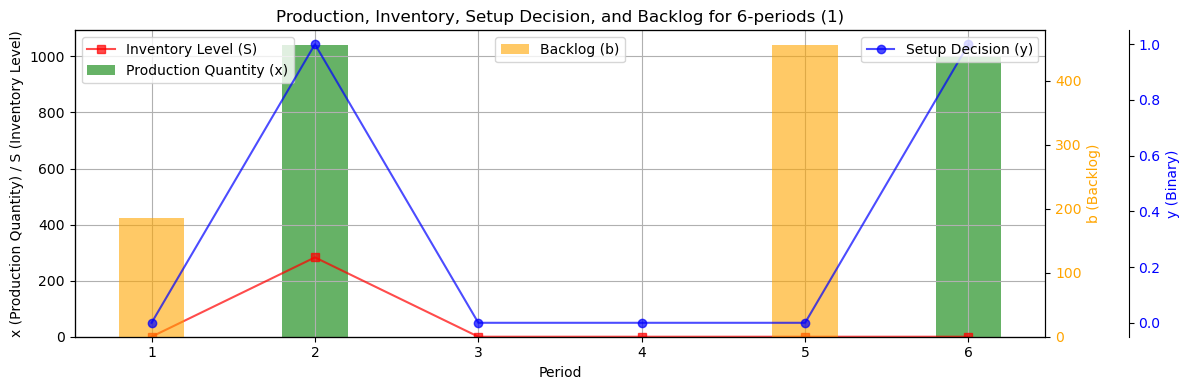

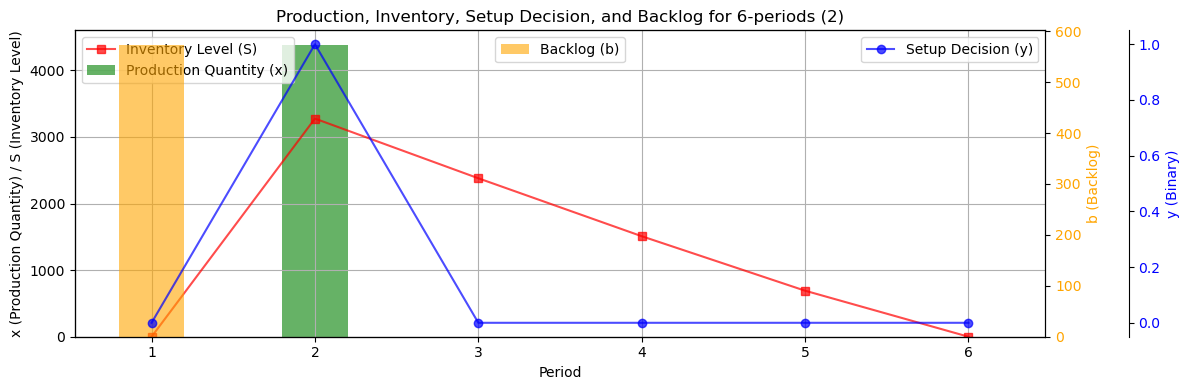

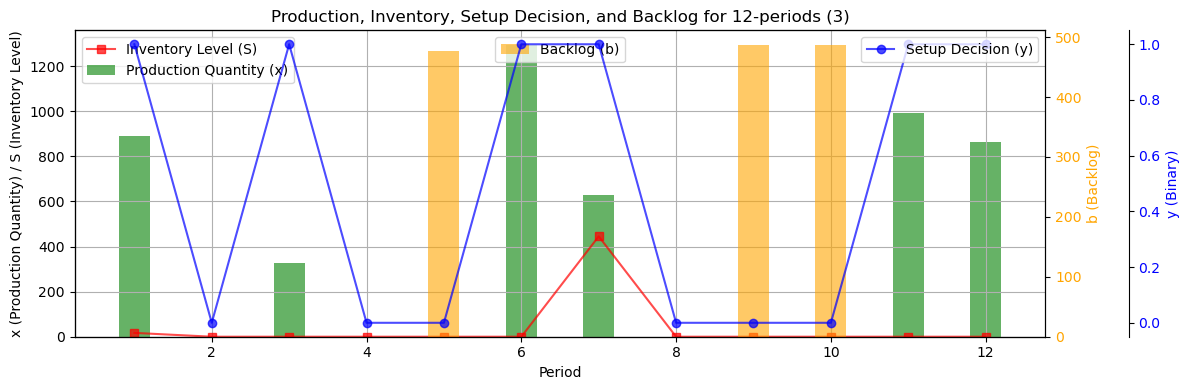

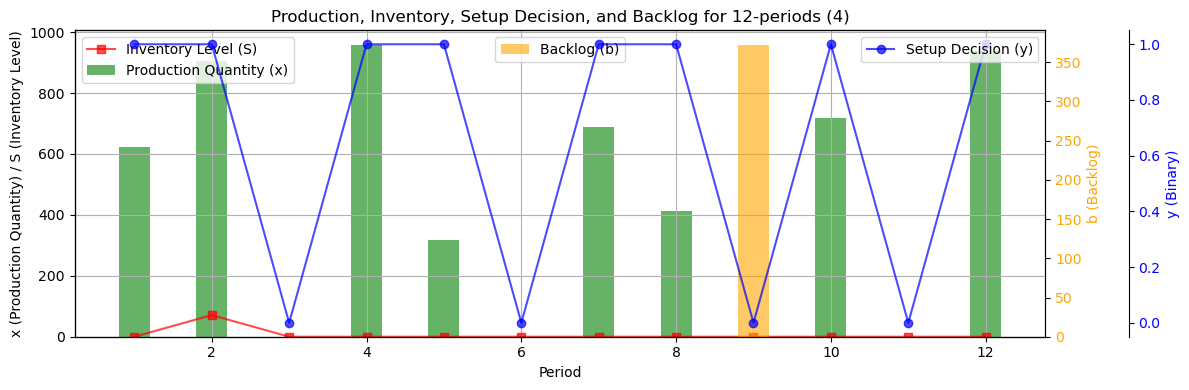

In [59]:
# Load the all_results CSV file into a DataFrame
#results_df = pd.read_csv("optimization_results.csv")

# Define function to plot data
def plot_data(data, sheet_name):
    fig, ax1 = plt.subplots(figsize=(12, 4))
    
    # Plot production quantity (x) as a bar chart
    ax1.bar(data['Period'], data['x'], color='g', width=0.4, label='Production Quantity (x)', alpha=0.6)
    
    # Plot inventory level (S) as a red line
    ax1.plot(data['Period'], data['S'], marker='s', linestyle='-', color='r', label='Inventory Level (S)', alpha=0.7)
    
    ax1.set_xlabel('Period')
    ax1.set_ylabel('x (Production Quantity) / S (Inventory Level)')
    ax1.tick_params(axis='y')

    # Create a second y-axis for backlog (b)
    ax2 = ax1.twinx()
    
    # Plot backlog (b) as a yellow block (bar)
    ax2.bar(data['Period'], data['b'], color='orange', label='Backlog (b)', alpha=0.6, width=0.4)
    ax2.set_ylabel('b (Backlog)', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Create a third y-axis for setup decision (y)
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Shift the third axis to avoid overlap
    
    # Plot setup decision (y) as a blue line
    ax3.plot(data['Period'], data['y'], marker='o', linestyle='-', color='b', label='Setup Decision (y)', alpha=0.7)
    ax3.set_ylabel('y (Binary)', color='b')
    ax3.tick_params(axis='y', labelcolor='b')

    plt.title(f'Production, Inventory, Setup Decision, and Backlog for {sheet_name}')
    ax1.grid(True)
    
    # Adding legends for all three y-axes
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper center')
    ax3.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Split the CSV into instances
sheet_ranges = [
    ("6-periods (1)", 0, 6),
    ("6-periods (2)", 6, 12),
    ("12-periods (3)", 12, 24),
    ("12-periods (4)", 24, 36)
]

for sheet_name, start_row, end_row in sheet_ranges:
    sheet_data = results_df.iloc[start_row:end_row]
    plot_data(sheet_data, sheet_name)


### **Zangwill Formulation**

In [61]:
def zangwill(demand, setup_costs, holding_costs, unit_costs, backlogging_costs, num_periods):

  T = num_periods  # Number of periods

  #DP tables for a and b
  A = np.full(T+1, float('inf'))
  B = np.full((T+1, T+1), float('inf'))
  Betas = np.zeros(T)
  Gammas = np.zeros(T)

  #base cases:
  A[T] = 0
  for epsilon in range(T+1):
    B[T][epsilon] = 0


  #first calculate b_T
  beta = T
  for epsilon in range(0, T):
      b_min = float('inf') #set the bar
      for gamma in range(T, T+1):

        b = (setup_costs[beta])

        b += unit_costs[beta] * sum(demand[beta-epsilon:gamma+1])

        b += sum(holding_costs[k] * sum(demand[k+1:gamma+1]) for k in range(beta, gamma))

        b += A[gamma]

        if b < b_min:
          b_min = b
          gamma_optimal = gamma

      #storage
      B[beta-1][epsilon] = b_min
      Gammas[beta-1] = gamma_optimal

  #backwards recursion through periods
  for t in range(T-1, -1, -1):


    #first we do a_t
    alpha = t #for clarity
    a_min = float('inf') #set the bar
    for beta in range(alpha+1, T+1):
      a = sum(backlogging_costs[k] * sum(demand[alpha+1:k+1]) for k in range(alpha+1, beta)) + B[beta-1][beta-alpha-1]
      if a <= a_min:
        a_min = a
        beta_optimal = beta
    #storage of optimal values
    A[alpha] = a_min
    Betas[alpha] = beta_optimal

    #now we do b_t
    beta = t
    for epsilon in range(0, beta):
      b_min = float('inf') #set the bar
      for gamma in range(beta, T+1):

        b = (setup_costs[beta])


        b += unit_costs[beta] * sum(demand[beta-epsilon:gamma+1])


        b += sum(holding_costs[k] * sum(demand[k+1:gamma+1]) for k in range(beta, gamma))

        b += A[gamma]

        #print(f'Setup Costs: { (setup_costs[beta])}')
        #print('Production Costs:', unit_costs[beta] * sum(demand[beta-epsilon:gamma+1]))
        #print('Holding Costs:', sum(holding_costs[k] * sum(demand[k+1:gamma+1]) for k in range(beta, gamma)))
        #print('Alfa Costs:', A[gamma])
        #print('b:', b)

        if b <= b_min:
          b_min = b
          gamma_optimal = gamma

      #storage
      B[beta-1][epsilon] = b_min
      Gammas[beta-1] = gamma_optimal
      #print('Gammas:', Gammas)


  return A[0], Betas, Gammas


def schedule_backlog(Betas, Gammas):
  N = len(Betas)
  t = 0

  while t <= N-1:
    t = int(Betas[t])
    print(f"Production in period { t}")
    t = int(Gammas[t-1])
    print(f"Regeneration in period { t}")

for sheet_name in sheet_list:
    print(f"\nProcessing sheet: {sheet_name}")

    # Read the Excel file from the specific sheet
    data=read_production_data(file_path, sheet_name)
    print(data)
    #print(data.demand_forecast[0])
    #print(data.holding_cost[0])

    min_cost, Betas, Gammas = zangwill(data.demand_forecast, data.setup_cost, data.holding_cost, data.production_cost, data.backlogging_cost, data.num_periods)
   # print(Betas)
    #print(Gammas)
    #print("Optimal order schedule:", optimal_orders)
    print("Minimum total cost:", min_cost)
    schedule_backlog(Betas, Gammas)


Processing sheet: 6-periods (1)
ProductionData(
  Demand Forecast: [  0 185 573 283   0 456 542]
  Setup Cost: [   0 2016 4377  817 2133 2572 1381]
  Production Cost: [  0 107  11  81 181  91   8]
  Holding Cost: [0 6 6 6 3 3 6]
  backlogging cost: [0 4 5 3 4 5 4]
  Number of Periods: 6

Minimum total cost: 29911.0
Production in period 2
Regeneration in period 4
Production in period 6
Regeneration in period 6

Processing sheet: 6-periods (2)
ProductionData(
  Demand Forecast: [  0 573 533 896 870 818 691]
  Setup Cost: [   0 1101 2789 4787 3406 3691 2724]
  Production Cost: [  0  21  14  85 140 178 144]
  Holding Cost: [0 3 7 3 2 4 3]
  backlogging cost: [0 3 3 4 5 5 5]
  Number of Periods: 6

Minimum total cost: 101686.0
Production in period 2
Regeneration in period 6

Processing sheet: 12-periods (1)
ProductionData(
  Demand Forecast: [  0 875  17 325   0 477 817 182 445 487   0 506 863]
  Setup Cost: [   0 2059 4342 1447 1889 1577 3605 2584 3825 1944  963 2903  508]
  Production Co

## 11. Shortest Path Reformulation (SPR)

In [65]:
results_df = pd.DataFrame(columns=["Sheet", "Period", "y", "w", "phi", "psi"])

sheet_list = ["6-periods (1)", "6-periods (2)", "12-periods (1)", "12-periods (2)", 
              "24-periods (1)", "24-periods (2)", "52-periods (1)", "52-periods (2)", 
              "104-periods (1)", "104-periods (2)"]
for sheet_name in sheet_list:
    print(f"\nProcessing sheet: {sheet_name}")

    data = read_production_data(file_path, sheet_name)

    T = data.num_periods
    M = sum(data.demand_forecast) 

    model = gp.Model("SPR_SI_ULSPwB")

    # Decision variables
    y = model.addVars(T+1, vtype=GRB.BINARY, name="y")  # Setup variables
    w = model.addVars(T+1, vtype=GRB.BINARY, name="w")  # Demand produced in period t
    phi = model.addVars(T+1, T+1, vtype=GRB.BINARY, name="phi")  # Demand coverage
    psi = model.addVars(T+1, T+1, vtype=GRB.BINARY, name="psi")  # Backlog coverage

    # Objective function
    model.setObjective(
        #Setup Costs
        quicksum(data.setup_cost[t] * y[t] for t in range(1, T+1)) +

        #Production Costs for period itself
        quicksum(data.production_cost[t] * data.demand_forecast[t] * w[t] for t in range(1, T+1)) +
        #Production costs for future demand
        quicksum(data.production_cost[t] * sum(data.demand_forecast[t+1: u+1]) * phi[t, u] for t in range(1, T+1) for u in range(t+1, T+1)) + 
        #production costs for backlogged demand
        quicksum(data.production_cost[t] * sum(data.demand_forecast[u: t]) * psi[t, u] for t in range(1, T+1) for u in range(1, t)) +

        #Holding Costs and Backlogging Costs
        quicksum(data.holding_cost[t] * sum(data.demand_forecast[t+1: l+1]) * phi[u, l] for t in range(0, T) for u in range(1, t+1) for l in range(t+1, T+1)) +
        quicksum(data.backlogging_cost[t] * sum(data.demand_forecast[l: t+1]) * psi[u, l]  for t in range(1, T+1) for u in range (t+1, T+1) for l in range(1, t+1)),  # backlogging cost
        GRB.MINIMIZE
     )

    #Constraints
    for t in range(2, T+1):

        #Node t: outflow is equal to inflow
        model.addConstr(
            quicksum(phi[k, t-1] for k in range(1, t)) - quicksum(psi[k, t] for k in range(t, T+1)) == 0
        )

    for t in range(1, T+1):
        
        #Node t': outflow is equal to inflow
        model.addConstr(
            -quicksum(psi[t, l] for l in range(1, t+1)) + w[t] == 0
        )
        
        #Node t'': outflow is equal to inflow
        model.addConstr(
            quicksum(phi[t, l] for l in range(t, T+1)) - w[t] == 0
        )

        #y == w
        model.addConstr(
            w[t] - y[t] <= 0,
            name=f"Production_{t}"
        )

    #Restricting 1
    model.addConstr(
        quicksum(psi[u, 1] for u in range(1, T+1)) == 1,
        name=f"No backlogging from 1"
    )

    
    
    model.optimize()

    # Collect results
    if model.status == GRB.OPTIMAL:
        results = {
            "y": [],
            "w": [],
            "phi": [[0] * T for _ in range(T)],  # Initialize phi as a T x T matrix
            "psi": [[0] * T for _ in range(T)]   # Initialize psi as a T x T matrix
        }

        for t in range(1, T+1):
            results["y"].append(y[t].X)
            results["w"].append(w[t].X)
            for u in range(1, T+1):
                results["phi"][u-1][t-1] = phi[u, t].X  # Store in matrix form
                results["psi"][u-1][t-1] = psi[u, t].X  # Store in matrix form

        for t in range(1, data.num_periods + 1):
            results_df = pd.concat([results_df, pd.DataFrame({
                "Sheet": [sheet_name],
                "Period": [t],
                "y": [results["y"][t-1]],
                "w": [results["w"][t-1]],
                "phi": [results["phi"]],
                "psi": [results["psi"]]
            })], ignore_index=True)

    else:
        print(f"No optimal solution found for sheet {sheet_name}.")

results_df.to_csv("SPR_results.csv", index=False)
print("\nResults saved to 'SPR_results.csv'.")


Processing sheet: 6-periods (1)
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 24 rows, 112 columns and 102 nonzeros
Model fingerprint: 0x1d763ec3
Variable types: 0 continuous, 112 integer (112 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e+02, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 181114.00000
Presolve removed 24 rows and 112 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 29911 181114 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.991100000000e+04, best bound 2.991100000000e+04, ga

C:\Users\Senne\AppData\Local\Temp\ipykernel_30288\2390491542.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 48 rows, 364 columns and 348 nonzeros
Model fingerprint: 0x75aabb61
Variable types: 0 continuous, 364 integer (364 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e+01, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 128217.00000
Presolve removed 48 rows and 364 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 53662 128217 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.366200000000e+04, best bound 5.366200000000e+04, gap 0.0000%

Processing sheet: 12-p

GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information

## 12. SPR with Relaxed Constraints.

In [68]:
import time

results_df = pd.DataFrame(columns=["Sheet", "Objective (Integer)", "Objective (Relaxed)", 
                                   "Time (Integer) [s]", "Time (Relaxed) [s]"])

sheet_list = ["6-periods (1)", "6-periods (2)", "12-periods (1)", "12-periods (2)", 
              "24-periods (1)", "24-periods (2)", "52-periods (1)", "52-periods (2)", 
              "104-periods (1)", "104-periods (2)"]

for sheet_name in sheet_list:
    print(f"\nProcessing sheet: {sheet_name}")
    
    data = read_production_data(file_path, sheet_name)
    T = data.num_periods

    # Original Model (MIP)
    model_integer = gp.Model("SPR_SI_ULSPwB_Integer")
    y_integer = model_integer.addVars(T+1, vtype=GRB.BINARY, name="y")
    w_integer = model_integer.addVars(T+1, vtype=GRB.BINARY, name="w")
    phi_integer = model_integer.addVars(T+1, T+1, vtype=GRB.BINARY, name="phi")
    psi_integer = model_integer.addVars(T+1, T+1, vtype=GRB.BINARY, name="psi")

    # Objective function for Integer Model
    model_integer.setObjective(
        quicksum(data.setup_cost[t] * y_integer[t] for t in range(1, T+1)) +
        quicksum(data.production_cost[t] * data.demand_forecast[t] * w_integer[t] for t in range(1, T+1)) +
        quicksum(data.production_cost[t] * sum(data.demand_forecast[t+1: u+1]) * phi_integer[t, u] for t in range(1, T+1) for u in range(t+1, T+1)) +
        quicksum(data.production_cost[t] * sum(data.demand_forecast[u: t]) * psi_integer[t, u] for t in range(1, T+1) for u in range(1, t)) +
        quicksum(data.holding_cost[t] * sum(data.demand_forecast[t+1: l+1]) * phi_integer[u, l] for t in range(0, T) for u in range(1, t+1) for l in range(t+1, T+1)) +
        quicksum(data.backlogging_cost[t] * sum(data.demand_forecast[l: t+1]) * psi_integer[u, l] for t in range(1, T+1) for u in range (t+1, T+1) for l in range(1, t+1)),
        GRB.MINIMIZE
    )

    # Constraints for Integer Model
    for t in range(2, T+1):
        model_integer.addConstr(
            quicksum(phi_integer[k, t-1] for k in range(1, t)) - quicksum(psi_integer[k, t] for k in range(t, T+1)) == 0
        )

    for t in range(1, T+1):
        model_integer.addConstr(-quicksum(psi_integer[t, l] for l in range(1, t+1)) + w_integer[t] == 0)
        model_integer.addConstr(quicksum(phi_integer[t, l] for l in range(t, T+1)) - w_integer[t] == 0)
        model_integer.addConstr(w_integer[t] - y_integer[t] <= 0, name=f"Production_{t}")
    
    model_integer.addConstr(
        quicksum(psi_integer[u, 1] for u in range(1, T+1)) == 1,
        name=f"No backlogging from 1"
    )
    
    # Track start time
    start_time_integer = time.time()
    model_integer.optimize()
    end_time_integer = time.time()
    time_integer = end_time_integer - start_time_integer

    # Relaxed Model (Continuous Model)
    model_relaxed = gp.Model("SPR_SI_ULSPwB_Relaxed")
    y_relaxed = model_relaxed.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, ub=1, name="y")
    w_relaxed = model_relaxed.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, ub=1, name="w")
    phi_relaxed = model_relaxed.addVars(T+1, T+1, vtype=GRB.CONTINUOUS, lb=0, ub=1, name="phi")
    psi_relaxed = model_relaxed.addVars(T+1, T+1, vtype=GRB.CONTINUOUS, lb=0, ub=1, name="psi")

    # Objective function for Relaxed Model
    model_relaxed.setObjective(
        quicksum(data.setup_cost[t] * y_relaxed[t] for t in range(1, T+1)) +
        quicksum(data.production_cost[t] * data.demand_forecast[t] * w_relaxed[t] for t in range(1, T+1)) +
        quicksum(data.production_cost[t] * sum(data.demand_forecast[t+1: u+1]) * phi_relaxed[t, u] for t in range(1, T+1) for u in range(t+1, T+1)) +
        quicksum(data.production_cost[t] * sum(data.demand_forecast[u: t]) * psi_relaxed[t, u] for t in range(1, T+1) for u in range(1, t)) +
        quicksum(data.holding_cost[t] * sum(data.demand_forecast[t+1: l+1]) * phi_relaxed[u, l] for t in range(0, T) for u in range(1, t+1) for l in range(t+1, T+1)) +
        quicksum(data.backlogging_cost[t] * sum(data.demand_forecast[l: t+1]) * psi_relaxed[u, l] for t in range(1, T+1) for u in range (t+1, T+1) for l in range(1, t+1)),
        GRB.MINIMIZE
    )

    # Constraints for Relaxed Model
    for t in range(2, T+1):
        model_relaxed.addConstr(
            quicksum(phi_relaxed[k, t-1] for k in range(1, t)) - quicksum(psi_relaxed[k, t] for k in range(t, T+1)) == 0
        )

    for t in range(1, T+1):
        model_relaxed.addConstr(-quicksum(psi_relaxed[t, l] for l in range(1, t+1)) + w_relaxed[t] == 0)
        model_relaxed.addConstr(quicksum(phi_relaxed[t, l] for l in range(t, T+1)) - w_relaxed[t] == 0)
        model_relaxed.addConstr(w_relaxed[t] - y_relaxed[t] <= 0, name=f"Production_{t}")
    
    model_relaxed.addConstr(
        quicksum(psi_relaxed[u, 1] for u in range(1, T+1)) == 1,
        name=f"No backlogging from 1"
    )

    # Track start time
    start_time_relaxed = time.time()
    model_relaxed.optimize()
    end_time_relaxed = time.time()
    time_relaxed = end_time_relaxed - start_time_relaxed

    # Check if both models are optimal and collect data
    if model_integer.status == GRB.OPTIMAL and model_relaxed.status == GRB.OPTIMAL:
        results_df = pd.concat([results_df, pd.DataFrame({
            "Sheet": [sheet_name],
            "Objective (Integer)": [model_integer.objVal],
            "Objective (Relaxed)": [model_relaxed.objVal],
            "Time (Integer) [s]": [time_integer],
            "Time (Relaxed) [s]": [time_relaxed]
        })], ignore_index=True)
    else:
        print(f"No optimal solution found for sheet {sheet_name}.")

# Save the results
results_df.to_csv("SPR_relaxed_results.csv", index=False)
print("\nComparison results (Objective and Time) saved to 'SPR_relaxed_results.csv'.")



Processing sheet: 6-periods (1)
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 24 rows, 112 columns and 102 nonzeros
Model fingerprint: 0x1d763ec3
Variable types: 0 continuous, 112 integer (112 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e+02, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 181114.00000
Presolve removed 24 rows and 112 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 29911 181114 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.991100000000e+04, best bound 2.991100000000e+04, ga

C:\Users\Senne\AppData\Local\Temp\ipykernel_30288\1512416682.py:98: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({



Processing sheet: 12-periods (1)
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 48 rows, 364 columns and 348 nonzeros
Model fingerprint: 0x75aabb61
Variable types: 0 continuous, 364 integer (364 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e+01, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 128217.00000
Presolve removed 48 rows and 364 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 53662 128217 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.366200000000e+04, best bound 5.366200000000e+04, g

GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information